In [10]:
import pymongo
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [17]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Connect to MongoDB
client = pymongo.MongoClient('mongodb://localhost:27017')
db = client['amazon_reviews_db']

# Collections
input_collection = db['preprocessed_reviews']  # Preprocessed reviews
output_collection = db['sentiment_reviews']  # New collection for sentiment results

In [ ]:
# Drop the output collection if it exists (to avoid duplicates during testing)
output_collection.drop()

In [3]:
# Filter reviews for "Reviewed in Canada"
reviews = input_collection.find({
    'original_review.review_date': {'$regex': 'Reviewed in Canada', '$options': 'i'}
})

In [4]:
# Lists to store sentiment results for visualization
sentiments = []

# Process each review
for review in reviews:
    review_text = review['original_review'].get('review_text', '')

    # Perform sentiment analysis
    sentiment_scores = analyzer.polarity_scores(review_text)
    compound_score = sentiment_scores['compound']

    # Classify as Positive or Negative
    sentiment = 'Positive' if compound_score >= 0 else 'Negative'

    # Store sentiment for visualization
    sentiments.append(sentiment)

    # Create a new document with sentiment results
    sentiment_review = {
        'original_review': review['original_review'],
        'sentences': review['sentences'],
        'tokenized_sentences': review['tokenized_sentences'],
        'sentiment': sentiment,
        'compound_score': compound_score
    }

    # Insert into the new collection
    output_collection.insert_one(sentiment_review)

client.close()

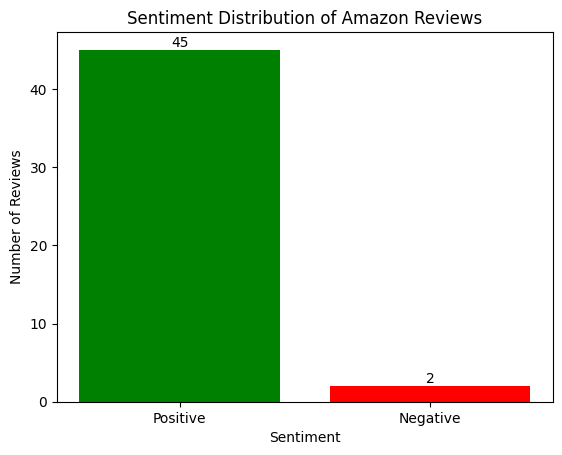

In [8]:
# Optional: Visualize sentiment distribution
if sentiments:
    # Count Positive and Negative reviews
    positive_count = sentiments.count('Positive')
    negative_count = sentiments.count('Negative')

    # Create a bar chart
    labels = ['Positive', 'Negative']
    counts = [positive_count, negative_count]
    bars = plt.bar(labels, counts, color=['green', 'red'])

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 str(height), ha='center', va='bottom', fontsize=10)

    plt.title('Sentiment Distribution of Amazon Reviews')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.show()
else:
    print("No reviews to visualize.")


### Sentiment analysis Grouped by ASIN number (product info) 

In [19]:
import re
url = 'https://www.amazon.ca/dp/B0DZ7L4M9C?th=1'

asin_to_product = {
    'B0DZ7L4M9C': 'Apple iPad',
    'B082PM6T1J': 'Tommy Jacket',
    'B0CQN248PX': 'Firestick',
    'B0BY13SMZW': 'KEOFID Backpack',
    'B08J4JRRCT': 'Samsung Monitor',
    'B07FTPX71F': 'DJI Mini Drone'
}

def extract_asin(url):
    match = re.search(r'/dp/([A-Z0-9]{10})', url)
    return match.group(1) if match else None

extract_asin(url)

'B0DZ7L4M9C'

In [21]:

# Aggregate sentiment counts by ASIN
asin_sentiment_counts = defaultdict(lambda: {'Positive': 0, 'Negative': 0})

for doc in output_collection.find():
    product_url = doc.get('original_review', {}).get('product_url', '')
    sentiment = doc.get('sentiment')
    asin = extract_asin(product_url)

    if asin and sentiment in ['Positive', 'Negative']:
        asin_sentiment_counts[asin][sentiment] += 1

# Filter only ASINs we have names for
asin_sentiment_counts = {asin: counts for asin, counts in asin_sentiment_counts.items() if asin in asin_to_product}

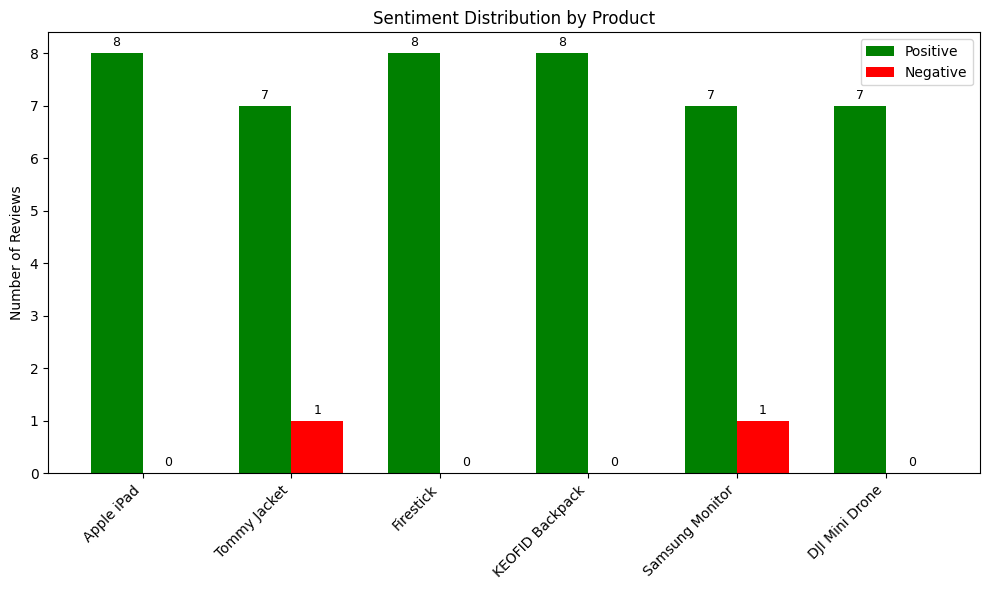

In [23]:
import numpy as np
# Prepare data for plotting
asins = list(asin_sentiment_counts.keys())
product_names = [asin_to_product[asin] for asin in asins]
positive_counts = [asin_sentiment_counts[asin]['Positive'] for asin in asins]
negative_counts = [asin_sentiment_counts[asin]['Negative'] for asin in asins]

x = np.arange(len(product_names))  # label locations
width = 0.35  # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive', color='green')
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative', color='red')

# Add labels and title
ax.set_ylabel('Number of Reviews')
ax.set_title('Sentiment Distribution by Product')
ax.set_xticks(x)
ax.set_xticklabels(product_names, rotation=45, ha='right')
ax.legend()

# Add value labels above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Wordcloud

In [30]:
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def generate_wordcloud(target_sentiment, output_collection):
    # Collect all review texts
    #target_sentiment = 'Positive'  # Change to 'Negative' for negative reviews
    all_text = ""
    for doc in output_collection.find({'sentiment': target_sentiment}):
        review_text = doc.get('original_review', {}).get('review_text', '')
        all_text += " " + review_text

    # Preprocess text
    stop_words = set(stopwords.words('english')).union(set(STOPWORDS))
    cleaned_text = re.sub(r'[^\w\s]', '', all_text)  # remove punctuation
    cleaned_text = cleaned_text.lower()

    # Generate word cloud
    wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        stopwords=stop_words, collocations=True).generate(cleaned_text)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Amazon Review Texts', fontsize=16)
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


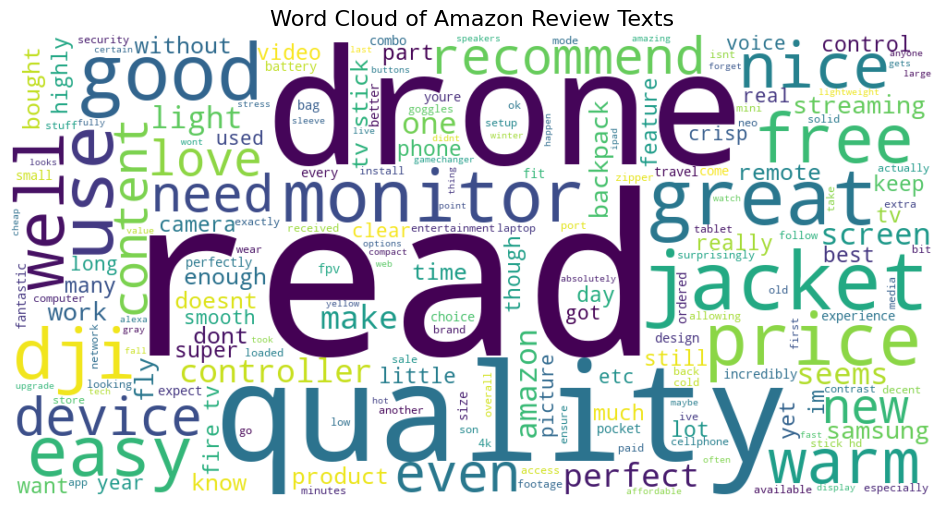

In [31]:
generate_wordcloud('Positive', output_collection)

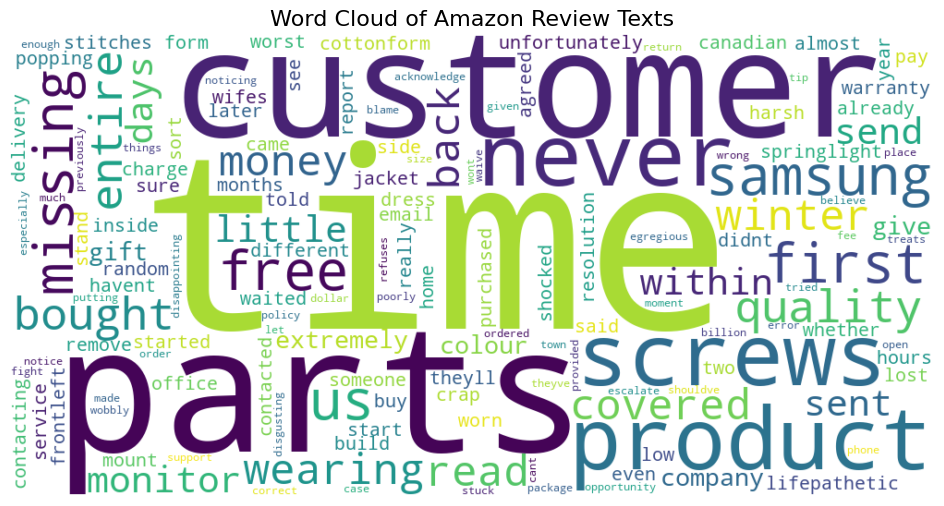

In [32]:
generate_wordcloud('Negative', output_collection)

### Most frequent positive and negative words 

In [33]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to extract and clean words
def get_word_frequencies(sentiment):
    all_text = ""
    for doc in output_collection.find({'sentiment': sentiment}):
        text = doc.get('original_review', {}).get('review_text', '')
        all_text += " " + text

    # Preprocess: lowercase, remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', all_text).lower()
    words = word_tokenize(cleaned_text)

    # Filter stopwords and short tokens
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    # Count frequencies
    return Counter(filtered_words)

In [35]:
# Get top N words
top_n = 15
positive_freq = get_word_frequencies('Positive')
negative_freq = get_word_frequencies('Negative')

print("\nTop Words in Positive Reviews:")
for word, count in positive_freq.most_common(top_n):
    print(f"{word}: {count}")



Top Words in Positive Reviews:
read: 46
like: 17
quality: 16
drone: 16
great: 14
good: 14
jacket: 14
use: 13
price: 12
monitor: 12
would: 11
easy: 11
dji: 11
well: 10
free: 10


In [36]:
print("\nTop Words in Negative Reviews:")
for word, count in negative_freq.most_common(top_n):
    print(f"{word}: {count}")


Top Words in Negative Reviews:
time: 4
parts: 4
product: 3
never: 3
screws: 3
samsung: 3
missing: 3
first: 3
free: 3
customer: 3
bought: 2
entire: 2
quality: 2
wearing: 2
winter: 2
